# 1. Kamlan_Filter Class

In [14]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [15]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

# 2. Implementing the Kalman Model

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt

import datetime
import pandas_datareader as web

In [17]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 1, 1)
df_amzn = web.DataReader('AMZN', 'yahoo', start, end) 
amzn= df_amzn
amzn=amzn.reset_index()
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn['lrets'] = (np.log(amzn.Close) - np.log(amzn.Close.shift(1))) * 100.
amzn.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Typical_Price,lrets
0,2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001,397.116659,NaN
1,2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002,398.456665,-0.385192
2,2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005,393.016673,-0.711332
3,2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999,396.930003,1.111598
4,2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013,400.320007,0.972572


C:\Users\Siddhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


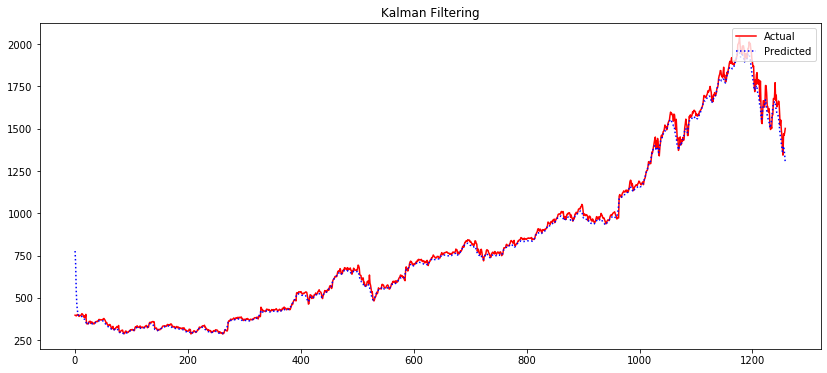

In [18]:
Y = amzn['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, y_pred,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [19]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(y_pred),
                  'Date':amzn['Date'],
                  'Open':amzn['Open'],
                  'Close':amzn['Close']
                       })


In [20]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2014-01-02,397.970001,777.276970,398.799988,397.970001
2014-01-03,396.440002,700.499279,398.290009,396.440002
2014-01-06,393.630005,546.121895,395.850006,393.630005
2014-01-07,398.029999,467.370682,395.040009,398.029999
2014-01-08,401.920013,427.745356,398.470001,401.920013
2014-01-09,401.010010,407.208938,403.709991,401.010010
2014-01-10,397.660004,396.624085,402.529999,397.660004
2014-01-13,390.980011,391.668170,397.980011,390.980011
2014-01-14,397.540009,391.673994,392.130005,397.540009


# 3.1 Long Short Day trading:
* if predicted > yesterdays close, buy and sell at end of day

* if predicted < yesterdays close, sell and buy at end of day

In [22]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)-1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
        
    else:
        action.append('Sell at Open & Bull at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
    print('\n')
        

0 Sell at Open 9970.0 - 25 50
0 Buy Back at Close 9999.25 0


1 Buy at Open 9957.25 25 88
1 Sell at Close 9999.0 0


2 Buy at Open 9896.25 25 158
2 Sell at Close 9998.75 0


3 Buy at Open 9876.0 25 48
3 Sell at Close 9998.75 0


4 Buy at Open 9961.75 25 352
4 Sell at Close 10400.0 0


5 Buy at Open 10092.75 25 374
5 Sell at Close 10399.25 0


6 Sell at Open 10063.25 - 25 60
6 Buy Back at Close 10001.5 0


7 Sell at Open 9949.5 - 25 226
7 Buy Back at Close 10000.5 0


8 Buy at Open 9803.25 25 62
8 Sell at Close 10000.5 0


9 Sell at Open 9973.5 - 25 103
9 Buy Back at Close 9999.75 0


10 Sell at Open 9842.0 - 25 104
10 Buy Back at Close 9999.0 0


11 Sell at Open 9856.5 - 25 8
11 Buy Back at Close 9998.25 0


12 Sell at Open 9672.0 - 24 229
12 Buy Back at Close 9998.2 0


13 Sell at Open 9792.0 - 24 289
13 Buy Back at Close 9997.96 0


14 Sell at Open 9624.0 - 24 1
14 Buy Back at Close 9597.88 0


15 Sell at Open 9555.84 - 24 295
15 Buy Back at Close 9597.4 0


16 Sell at Open 9372.0 - 

163 Sell at Close 6311.94 0


164 Sell at Open 6157.62 - 18 134
164 Buy Back at Close 6311.24 0


165 Sell at Open 6120.0 - 18 190
165 Buy Back at Close 6310.36 0


166 Sell at Open 6151.68 - 18 207
166 Buy Back at Close 6309.72 0


167 Sell at Open 6119.64 - 18 146
167 Buy Back at Close 6308.84 0


168 Sell at Open 6165.72 - 18 206
168 Buy Back at Close 6308.0 0


169 Sell at Open 6186.42 - 18 80
169 Buy Back at Close 6307.1 0


170 Sell at Open 6233.4 - 18 72
170 Buy Back at Close 6306.84 0


171 Sell at Open 6201.72 - 18 144
171 Buy Back at Close 6306.12 0


172 Sell at Open 6148.98 - 18 40
172 Buy Back at Close 5975.5 0


173 Sell at Open 5683.1 - 17 11
173 Buy Back at Close 5643.61 0


174 Sell at Open 5608.98 - 17 24
174 Buy Back at Close 5642.84 0


175 Sell at Open 5602.52 - 17 12
175 Buy Back at Close 5642.23 0


176 Sell at Open 5625.47 - 17 136
176 Buy Back at Close 5642.13 0


177 Sell at Open 5458.19 - 17 70
177 Buy Back at Close 5641.92 0


178 Sell at Open 5571.92 - 17 1

348 Sell at Open 5992.0 - 14 322
348 Buy Back at Close 6364.82 0


349 Sell at Open 6041.7 - 14 378
349 Buy Back at Close 6364.82 0


350 Sell at Open 5966.8 - 14 408
350 Buy Back at Close 6364.58 0


351 Sell at Open 5984.3 - 14 324
351 Buy Back at Close 6363.88 0


352 Sell at Open 6015.94 - 14 391
352 Buy Back at Close 6362.98 0


353 Sell at Open 5981.22 - 14 353
353 Buy Back at Close 6362.22 0


354 Sell at Open 6025.6 - 14 329
354 Buy Back at Close 6361.88 0


355 Sell at Open 6020.98 - 14 328
355 Buy Back at Close 6361.86 0


356 Sell at Open 6081.6 - 14 249
356 Buy Back at Close 6361.26 0


357 Sell at Open 6081.6 - 14 330
357 Buy Back at Close 6360.92 0


358 Sell at Open 6015.24 - 14 383
358 Buy Back at Close 6360.3 0


359 Sell at Open 5958.68 - 14 7
359 Buy Back at Close 5936.0 0


360 Sell at Open 5921.44 - 14 404
360 Buy Back at Close 6360.72 0


361 Sell at Open 5970.44 - 14 329
361 Buy Back at Close 6359.78 0


362 Sell at Open 6052.06 - 14 298
362 Buy Back at Close 635

537 Sell at Close 4363.5 0


538 Sell at Open 3888.85 - 7 492
538 Buy Back at Close 4362.58 0


539 Sell at Open 3820.25 - 7 484
539 Buy Back at Close 4362.28 0


540 Sell at Open 3888.64 - 7 476
540 Buy Back at Close 4362.05 0


541 Sell at Open 3920.84 - 7 475
541 Buy Back at Close 4361.61 0


542 Buy at Open 3878.0 7 493
542 Sell at Close 4360.64 0


543 Buy at Open 3894.03 7 307
543 Sell at Close 4360.28 0


544 Sell at Open 4072.25 - 7 298
544 Buy Back at Close 4359.47 0


545 Sell at Open 4045.72 - 7 317
545 Buy Back at Close 4359.43 0


546 Sell at Open 4067.49 - 7 333
546 Buy Back at Close 4358.98 0


547 Sell at Open 4014.78 - 7 419
547 Buy Back at Close 4358.6 0


548 Sell at Open 3905.09 - 7 436
548 Buy Back at Close 4357.82 0


549 Sell at Open 3916.92 - 7 441
549 Buy Back at Close 4357.29 0


550 Sell at Open 3967.18 - 7 444
550 Buy Back at Close 4356.51 0


551 Buy at Open 3968.65 7 369
551 Sell at Close 4356.27 0


552 Sell at Open 3969.0 - 7 342
552 Buy Back at Close 43

722 Buy Back at Close 3376.04 0


723 Sell at Open 2982.04 - 4 499
723 Buy Back at Close 3375.28 0


724 Buy at Open 2920.0 4 402
724 Sell at Close 3374.96 0


725 Buy at Open 2959.52 4 389
725 Sell at Close 3374.96 0


726 Buy at Open 2997.28 4 349
726 Sell at Close 3374.6 0


727 Buy at Open 3044.0 4 333
727 Sell at Close 3373.64 0


728 Buy at Open 3064.0 4 253
728 Sell at Close 3373.0 0


729 Sell at Open 3152.68 - 4 231
729 Buy Back at Close 3372.32 0


730 Sell at Open 3126.92 - 4 251
730 Buy Back at Close 3371.48 0


731 Sell at Open 3146.0 - 4 250
731 Buy Back at Close 3371.48 0


732 Sell at Open 3107.96 - 4 304
732 Buy Back at Close 3371.08 0


733 Sell at Open 3072.0 - 4 321
733 Buy Back at Close 3371.08 0


734 Sell at Open 3048.0 - 4 368
734 Buy Back at Close 3370.28 0


735 Sell at Open 3009.64 - 4 395
735 Buy Back at Close 3369.6 0


736 Sell at Open 2973.6 - 4 408
736 Buy Back at Close 3369.36 0


737 Buy at Open 2980.0 4 331
737 Sell at Close 3368.44 0


738 Sell at Op

887 Sell at Open 1000.65 - 1 7
887 Buy Back at Close 1013.51 0


888 Sell at Open 1004.62 - 1 12
888 Buy Back at Close 1012.63 0


889 Sell at Open 1002.4 - 1 10
889 Buy Back at Close 1011.81 0


890 Buy at Open 1004.69 1 1
890 Sell at Close 1011.04 0


891 Sell at Open 1006.0 - 1 1011
891 Buy Back at Close 2035.45 0


892 Sell at Open 1025.0 - 1 1008
892 Buy Back at Close 2034.87 0


893 Sell at Open 1031.59 - 1 1006
893 Buy Back at Close 2034.7 0


894 Sell at Open 1021.28 - 1 1009
894 Buy Back at Close 2034.67 0


895 Sell at Open 1028.34 - 1 995
895 Buy Back at Close 2033.95 0


896 Sell at Open 1038.05 - 1 994
896 Buy Back at Close 2033.87 0


897 Sell at Open 1043.2 - 1 981
897 Buy Back at Close 2033.8 0


898 Sell at Open 1069.55 - 1 987
898 Buy Back at Close 2033.0 0


899 Sell at Open 2024.28 - 2 1012
899 Buy Back at Close 3052.08 0


900 Sell at Open 2038.1 - 2 88
900 Buy Back at Close 2063.56 0


901 Sell at Open 1992.22 - 2 71
901 Buy Back at Close 2063.38 0


902 Sell at O

1066 Sell at Open 1447.0 - 1 547
1066 Buy Back at Close 1978.42 0


1067 Sell at Open 1406.0 - 1 531
1067 Buy Back at Close 1978.34 0


1068 Sell at Open 1417.62 - 1 606
1068 Buy Back at Close 1977.99 0


1069 Buy at Open 1391.38 1 585
1069 Sell at Close 1977.05 0


1070 Buy at Open 1358.24 1 566
1070 Sell at Close 1976.57 0


1071 Sell at Open 1441.99 - 1 524
1071 Buy Back at Close 1975.75 0


1072 Sell at Open 1429.97 - 1 570
1072 Buy Back at Close 1975.23 0


1073 Buy at Open 1425.03 1 569
1073 Sell at Close 1975.08 0


1074 Buy at Open 1431.99 1 538
1074 Sell at Close 1974.22 0


1075 Sell at Open 1439.44 - 1 547
1075 Buy Back at Close 1974.05 0


1076 Buy at Open 1439.5 1 525
1076 Sell at Close 1973.5 0


1077 Sell at Open 1449.14 - 1 542
1077 Buy Back at Close 1972.79 0


1078 Buy at Open 1445.0 1 531
1078 Sell at Close 1972.5 0


1079 Buy at Open 1462.3 1 468
1079 Sell at Close 1971.83 0


1080 Sell at Open 1514.65 - 1 443
1080 Buy Back at Close 1970.84 0


1081 Sell at Open 154

1242 Buy Back at Close 3906.26 0


1243 Sell at Open 3247.68 - 2 624
1243 Buy Back at Close 3906.06 0


1244 Sell at Open 3356.0 - 2 619
1244 Buy Back at Close 3905.48 0


1245 Sell at Open 3338.0 - 2 578
1245 Buy Back at Close 3905.08 0


1246 Sell at Open 3360.0 - 2 588
1246 Buy Back at Close 3904.76 0


1247 Sell at Open 3276.0 - 2 720
1247 Buy Back at Close 3903.82 0


1248 Sell at Open 3132.0 - 2 862
1248 Buy Back at Close 3903.82 0


1249 Sell at Open 3080.0 - 2 800
1249 Buy Back at Close 3902.96 0


1250 Sell at Open 3086.1 - 2 912
1250 Buy Back at Close 3902.16 0


1251 Sell at Open 2968.0 - 2 980
1251 Buy Back at Close 3901.66 0


1252 Sell at Open 2929.98 - 2 1146
1252 Buy Back at Close 3900.9 0


1253 Sell at Open 2692.0 - 2 1212
1253 Buy Back at Close 3899.92 0


1254 Buy at Open 2737.78 2 958
1254 Sell at Close 3899.8 0


1255 Sell at Open 2908.4 - 2 976
1255 Buy Back at Close 3899.28 0


1256 Sell at Open 2946.7 - 2 943
1256 Buy Back at Close 3899.04 0




In [23]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Sell at Open & Bull at Close,0,9999.250031
2,393.630005,546.121895,2014-01-06,Buy at Open & Sell at Close,0,9999.000061
3,398.029999,467.370682,2014-01-07,Buy at Open & Sell at Close,0,9998.750122
4,401.920013,427.745356,2014-01-08,Buy at Open & Sell at Close,0,9998.749969
5,401.010010,407.208938,2014-01-09,Buy at Open & Sell at Close,0,10400.000336


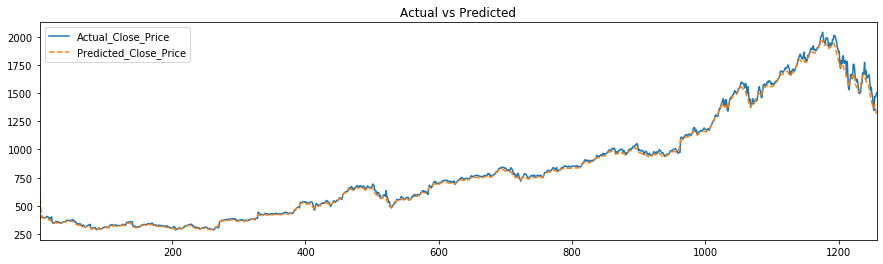

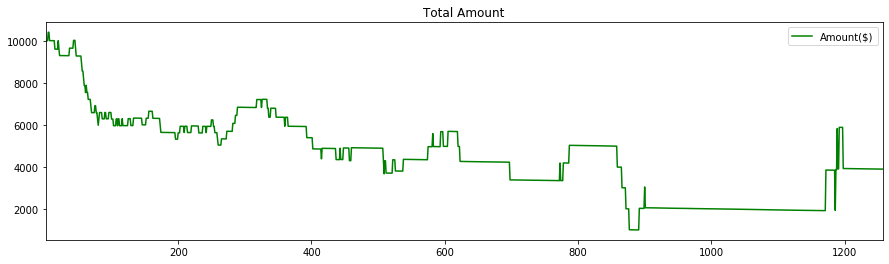

In [24]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [25]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 3899.0400390625 $
Profit_Percent: 38.990400390625 %


* Sharpe Ratio

In [27]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [28]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0011284359328211418 0.06726213328360986


0.4968280031452998

# 3.2 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [29]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['Actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['Actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 397.9700012207031 Action: Buy Portfolio: 9949.25 Stocks: 25 Balance_init: 50 total($) 9999.25


Stock: 396.44000244140625 Action: Bought--Holding Portfolio: 9911.0 Stocks: 25 Balance_init: 50 total($) 9961.0


Stock: 393.6300048828125 Action: Bought--Holding Portfolio: 9840.75 Stocks: 25 Balance_init: 50 total($) 9890.75


Stock: 398.0299987792969 Action: Bought--Holding Portfolio: 9950.75 Stocks: 25 Balance_init: 50 total($) 10000.75


Stock: 401.9200134277344 Action: Bought--Holding Portfolio: 10048.0 Stocks: 25 Balance_init: 50 total($) 10098.0


Stock: 401.010009765625 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10075.25


Stock: 397.6600036621094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10075.25


Stock: 390.9800109863281 Action: Buy Portfolio: 9774.5 Stocks: 25 Balance_init: 300 total($) 10074.5


Stock: 397.5400085449219 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10238.5


Stock: 395.86999511

Stock: 326.2799987792969 Action: Bought--Holding Portfolio: 16314.0 Stocks: 50 Balance_init: 136 total($) 16450.0


Stock: 333.2099914550781 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 333.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 334.5299987792969 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 335.1300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 335.7799987792969 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 332.9100036621094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16796.5


Stock: 331.5899963378906 Action: Buy Portfolio: 16579.5 Stocks: 50 Balance_init: 216 total($) 16795.5


Stock: 334.0199890136719 Action: Bought--Holding Portfolio: 16701.0 Stocks

Stock: 374.4100036621094 Action: Buy Portfolio: 27706.34 Stocks: 74 Balance_init: 256 total($) 27962.34


Stock: 381.20001220703125 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 383.5400085449219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 382.6499938964844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 382.3599853515625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 385.1099853515625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 383.45001220703125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 386.0400085449219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28464.8


Stock: 375.55999755859375 Action: Buy Portfolio: 28167.0 Stocks:

Stock: 661.27001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 668.4500122070312 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 678.989990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 671.1500244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 675.3400268554688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 673.260009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 664.7999877929688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 679.0599975585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71976.32


Stock: 676.010009765

Stock: 768.5599975585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 771.239990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 772.5599975585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 768.489990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 764.0399780273438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 764.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 764.4600219726562 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 757.3099975585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 142835.29


Stock: 759

Stock: 995.9500122070312 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 1006.72998046875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 1011.3400268554688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 1003.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 1010.0700073242188 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 1010.27001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 978.3099975585938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 964.9099731445312 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 236187.99


Stock: 980.78997802

Stock: 1254.3299560546875 Action: Bought--Holding Portfolio: 354975.38 Stocks: 283 Balance_init: 782 total($) 355757.38


Stock: 1276.6800537109375 Action: Bought--Holding Portfolio: 361300.46 Stocks: 283 Balance_init: 782 total($) 362082.46


Stock: 1305.199951171875 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 370153.59


Stock: 1304.8599853515625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 370153.59


Stock: 1295.0 Action: Buy Portfolio: 369075.0 Stocks: 285 Balance_init: 1078 total($) 370153.0


Stock: 1293.3199462890625 Action: Bought--Holding Portfolio: 368596.18 Stocks: 285 Balance_init: 1078 total($) 369674.18


Stock: 1294.5799560546875 Action: Bought--Holding Portfolio: 368955.29 Stocks: 285 Balance_init: 1078 total($) 370033.29


Stock: 1327.31005859375 Action: Bought--Holding Portfolio: 378283.37 Stocks: 285 Balance_init: 1078 total($) 379361.37


Stock: 1362.5400390625 Action: Bought--Holding Portfolio: 388323.91 S

Stock: 1883.4200439453125 Action: Buy Portfolio: 664847.28 Stocks: 353 Balance_init: 1814 total($) 666661.28


Stock: 1904.9000244140625 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 674243.71


Stock: 1902.9000244140625 Action: Buy Portfolio: 673626.61 Stocks: 354 Balance_init: 617 total($) 674243.61


Stock: 1905.3900146484375 Action: Bought--Holding Portfolio: 674508.07 Stocks: 354 Balance_init: 617 total($) 675125.07


Stock: 1927.6800537109375 Action: Bought--Holding Portfolio: 682398.74 Stocks: 354 Balance_init: 617 total($) 683015.74


Stock: 1932.8199462890625 Action: Bought--Holding Portfolio: 684218.26 Stocks: 354 Balance_init: 617 total($) 684835.26


Stock: 1998.0999755859375 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 707944.39


Stock: 2002.3800048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 707944.39


Stock: 2012.7099609375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balan

In [30]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Buy,25,9949.25003,9999.0
2,393.630005,546.121895,2014-01-06,Bought--Holding,25,9911.00006,9961.0
3,398.029999,467.370682,2014-01-07,Bought--Holding,25,9840.75012,9891.0
4,401.920013,427.745356,2014-01-08,Bought--Holding,25,9950.74997,10001.0
5,401.010010,407.208938,2014-01-09,Bought--Holding,25,10048.00034,10098.0


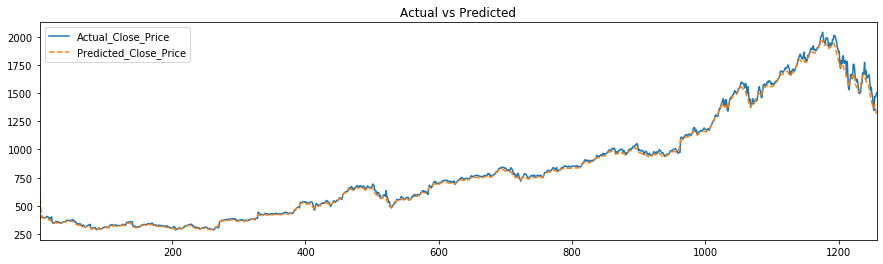

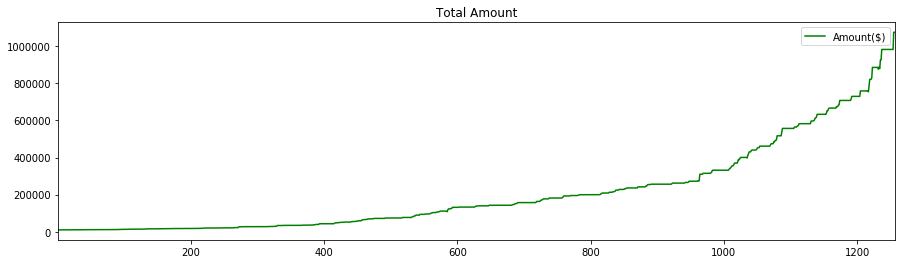

In [31]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [32]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 1075656.0 $
Profit_Percent: 10756.56 %


* Sharpe Ratio

In [33]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [34]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.003801043380943083 0.012059451562487394


9.334156225557479

# 3.3 Buy & Hold Trading Strategy with bolling bands

In [35]:
long_MA = results['Actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [36]:
short_MA  = results['Actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [37]:
long_std= results['Actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [38]:

long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [39]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

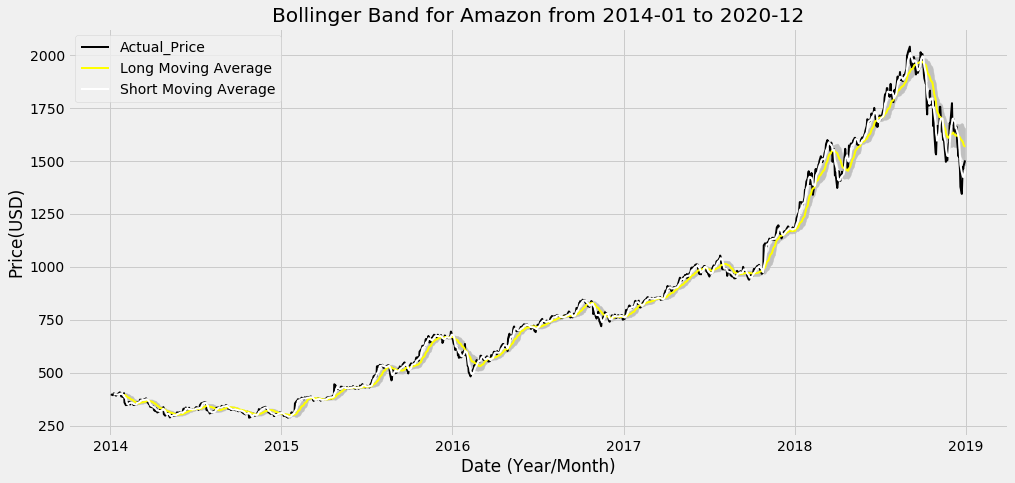

In [40]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='silver')
ax.plot(x_axis, results['Actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='white', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Amazon from 2014-01 to 2020-12')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

In [41]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i] > results['Long_Lower_Band'][i]:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i] < results['Long_Moving_Avg'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Do nothing')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')
    

Stock: 397.9700012207031 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 396.44000244140625 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 393.6300048828125 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 398.0299987792969 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 401.9200134277344 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 401.010009765625 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 397.6600036621094 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 390.9800109863281 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 397.5400085449219 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 395.8699951171875 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000




Stock: 323.80999755859375 Action: Bought--Holding Portfolio: 11333.35 Stocks: 35 Balance_init: 180 total($) 11513.35


Stock: 329.9700012207031 Action: Bought--Holding Portfolio: 11548.95 Stocks: 35 Balance_init: 180 total($) 11728.95


Stock: 327.9200134277344 Action: Bought--Holding Portfolio: 11477.2 Stocks: 35 Balance_init: 180 total($) 11657.2


Stock: 346.20001220703125 Action: Bought--Holding Portfolio: 12117.0 Stocks: 35 Balance_init: 180 total($) 12297.0


Stock: 355.32000732421875 Action: Bought--Holding Portfolio: 12436.2 Stocks: 35 Balance_init: 180 total($) 12616.2


Stock: 354.44000244140625 Action: Bought--Holding Portfolio: 12405.4 Stocks: 35 Balance_init: 180 total($) 12585.4


Stock: 355.8999938964844 Action: Bought--Holding Portfolio: 12456.5 Stocks: 35 Balance_init: 180 total($) 12636.5


Stock: 352.45001220703125 Action: Bought--Holding Portfolio: 12335.75 Stocks: 35 Balance_init: 180 total($) 12515.75


Stock: 358.6600036621094 Action: Bought--Holding Portfolio: 1



Stock: 306.07000732421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 295.05999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 298.8800048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 297.7300109863281 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 299.8999938964844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 306.5400085449219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 306.2900085449219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 303.0299987792969 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14580.0


Stock: 309.089996337

Stock: 482.17999267578125 Action: Bought--Holding Portfolio: 25073.36 Stocks: 52 Balance_init: 34 total($) 25107.36


Stock: 529.4199829101562 Action: Bought--Holding Portfolio: 27529.84 Stocks: 52 Balance_init: 34 total($) 27563.84


Stock: 531.4099731445312 Action: Bought--Holding Portfolio: 27633.32 Stocks: 52 Balance_init: 34 total($) 27667.32


Stock: 526.030029296875 Action: Bought--Holding Portfolio: 27353.56 Stocks: 52 Balance_init: 34 total($) 27387.56


Stock: 529.0 Action: Bought--Holding Portfolio: 27508.0 Stocks: 52 Balance_init: 34 total($) 27542.0


Stock: 536.760009765625 Action: Bought--Holding Portfolio: 27911.52 Stocks: 52 Balance_init: 34 total($) 27945.52


Stock: 536.1500244140625 Action: Bought--Holding Portfolio: 27879.8 Stocks: 52 Balance_init: 34 total($) 27913.8


Stock: 535.030029296875 Action: Bought--Holding Portfolio: 27821.56 Stocks: 52 Balance_init: 34 total($) 27855.56


Stock: 531.9000244140625 Action: Bought--Holding Portfolio: 27658.8 Stocks: 52 Bal

Stock: 559.5 Action: Bought--Holding Portfolio: 39724.5 Stocks: 71 Balance_init: 65 total($) 39789.5


Stock: 552.9400024414062 Action: Bought--Holding Portfolio: 39258.74 Stocks: 71 Balance_init: 65 total($) 39323.74


Stock: 554.0399780273438 Action: Bought--Holding Portfolio: 39336.84 Stocks: 71 Balance_init: 65 total($) 39401.84


Stock: 555.1500244140625 Action: Bought--Holding Portfolio: 39415.65 Stocks: 71 Balance_init: 65 total($) 39480.65


Stock: 555.22998046875 Action: Bought--Holding Portfolio: 39421.33 Stocks: 71 Balance_init: 65 total($) 39486.33


Stock: 552.52001953125 Action: Bought--Holding Portfolio: 39228.92 Stocks: 71 Balance_init: 65 total($) 39293.92


Stock: 579.0399780273438 Action: Bought--Holding Portfolio: 41111.84 Stocks: 71 Balance_init: 65 total($) 41176.84


Stock: 580.2100219726562 Action: Bought--Holding Portfolio: 41194.91 Stocks: 71 Balance_init: 65 total($) 41259.91


Stock: 577.489990234375 Action: Bought--Holding Portfolio: 41001.79 Stocks: 71 Bal

Stock: 772.4400024414062 Action: Buy Portfolio: 54843.24 Stocks: 71 Balance_init: 61 total($) 54904.24


Stock: 788.8699951171875 Action: Bought--Holding Portfolio: 56009.77 Stocks: 71 Balance_init: 61 total($) 56070.77


Stock: 784.47998046875 Action: Bought--Holding Portfolio: 55698.08 Stocks: 71 Balance_init: 61 total($) 55759.08


Stock: 784.0599975585938 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 55729.26


Stock: 760.1400146484375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 55729.26


Stock: 771.489990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 55729.26


Stock: 761.010009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 55729.26


Stock: 761.0900268554688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 55729.26


Stock: 769.6900024414062 Action: Buy Portfolio: 55417.68 Stocks: 72 Balance_

Stock: 876.3400268554688 Action: Bought--Holding Portfolio: 70107.2 Stocks: 80 Balance_init: 243 total($) 70350.2


Stock: 886.5399780273438 Action: Bought--Holding Portfolio: 70923.2 Stocks: 80 Balance_init: 243 total($) 71166.2


Stock: 891.510009765625 Action: Bought--Holding Portfolio: 71320.8 Stocks: 80 Balance_init: 243 total($) 71563.8


Stock: 906.8300170898438 Action: Bought--Holding Portfolio: 72546.4 Stocks: 80 Balance_init: 243 total($) 72789.4


Stock: 909.280029296875 Action: Bought--Holding Portfolio: 72742.4 Stocks: 80 Balance_init: 243 total($) 72985.4


Stock: 898.280029296875 Action: Bought--Holding Portfolio: 71862.4 Stocks: 80 Balance_init: 243 total($) 72105.4


Stock: 894.8800048828125 Action: Bought--Holding Portfolio: 71590.4 Stocks: 80 Balance_init: 243 total($) 71833.4


Stock: 907.0399780273438 Action: Bought--Holding Portfolio: 72563.2 Stocks: 80 Balance_init: 243 total($) 72806.2


Stock: 902.3599853515625 Action: Bought--Holding Portfolio: 72188.8 Stocks:

Stock: 1136.8399658203125 Action: Bought--Holding Portfolio: 97768.24 Stocks: 86 Balance_init: 897 total($) 98665.24


Stock: 1126.68994140625 Action: Bought--Holding Portfolio: 96895.33 Stocks: 86 Balance_init: 897 total($) 97792.33


Stock: 1137.2900390625 Action: Bought--Holding Portfolio: 97806.94 Stocks: 86 Balance_init: 897 total($) 98703.94


Stock: 1129.8800048828125 Action: Bought--Holding Portfolio: 97169.68 Stocks: 86 Balance_init: 897 total($) 98066.68


Stock: 1126.31005859375 Action: Bought--Holding Portfolio: 96862.67 Stocks: 86 Balance_init: 897 total($) 97759.67


Stock: 1139.489990234375 Action: Bought--Holding Portfolio: 97996.14 Stocks: 86 Balance_init: 897 total($) 98893.14


Stock: 1156.1600341796875 Action: Bought--Holding Portfolio: 99429.76 Stocks: 86 Balance_init: 897 total($) 100326.76


Stock: 1186.0 Action: Bought--Holding Portfolio: 101996.0 Stocks: 86 Balance_init: 897 total($) 102893.0


Stock: 1195.8299560546875 Action: Bought--Holding Portfolio: 102841


Stock: 1693.9599609375 Action: Buy Portfolio: 155844.32 Stocks: 92 Balance_init: 1162 total($) 157006.32


Stock: 1699.72998046875 Action: Bought--Holding Portfolio: 156375.16 Stocks: 92 Balance_init: 1162 total($) 157537.16


Stock: 1710.6300048828125 Action: Bought--Holding Portfolio: 157377.96 Stocks: 92 Balance_init: 1162 total($) 158539.96


Stock: 1739.02001953125 Action: Bought--Holding Portfolio: 159989.84 Stocks: 92 Balance_init: 1162 total($) 161151.84


Stock: 1743.0699462890625 Action: Bought--Holding Portfolio: 160362.44 Stocks: 92 Balance_init: 1162 total($) 161524.44


Stock: 1755.0 Action: Bought--Holding Portfolio: 161460.0 Stocks: 92 Balance_init: 1162 total($) 162622.0


Stock: 1796.6199951171875 Action: Bought--Holding Portfolio: 165289.04 Stocks: 92 Balance_init: 1162 total($) 166451.04


Stock: 1813.030029296875 Action: Bought--Holding Portfolio: 166798.76 Stocks: 92 Balance_init: 1162 total($) 167960.76


Stock: 1822.489990234375 Action: Bought--Holding Portfoli

In [42]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Do nothing,0,0.0,10000.0
2,393.630005,546.121895,2014-01-06,Do nothing,0,0.0,10000.0
3,398.029999,467.370682,2014-01-07,Do nothing,0,0.0,10000.0
4,401.920013,427.745356,2014-01-08,Do nothing,0,0.0,10000.0
5,401.010010,407.208938,2014-01-09,Do nothing,0,0.0,10000.0


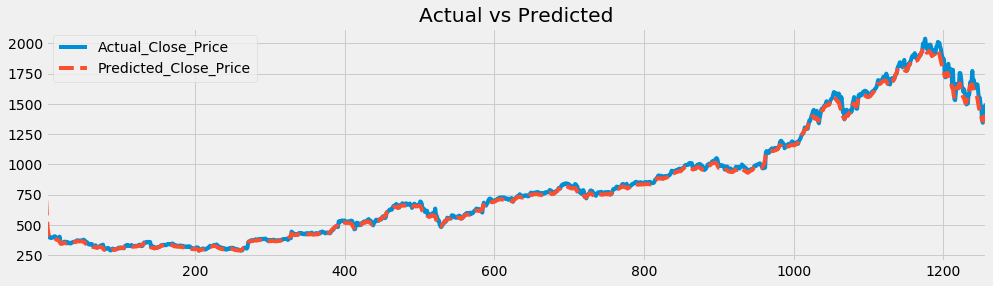

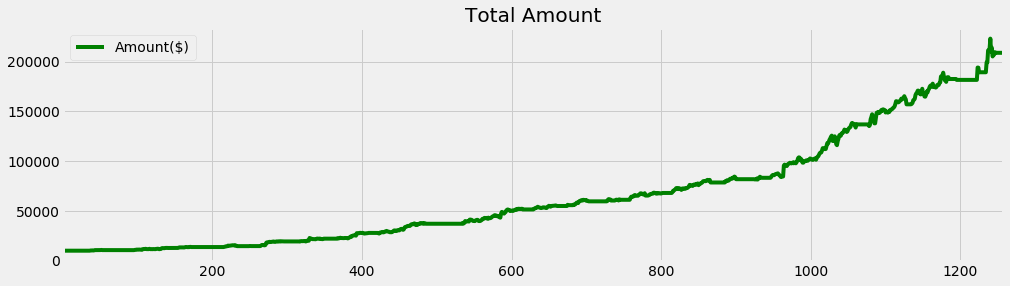

In [43]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [44]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 208744.0 $
Profit_Percent: 2087.44 %


* Sharpe Ratio

In [45]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [46]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.002508106131459621 0.013314383147163463


5.5785927246438645

# 3.4 Buy & Hold Trading Strategy with Macd

In [47]:
import numpy as np
import pandas as pd
def calculateEMA(period, closeArray, emaArray=[]):
    length = len(closeArray)
    nanCounter = np.count_nonzero(np.isnan(closeArray))
    if not emaArray:
        emaArray.extend(np.tile([np.nan],(nanCounter + period - 1)))
        firstema = np.mean(closeArray[nanCounter:nanCounter + period - 1])    
        emaArray.append(firstema)    
        for i in range(nanCounter+period,length):
            ema=(2*closeArray[i]+(period-1)*emaArray[-1])/(period+1)
            emaArray.append(ema)        
    return np.array(emaArray)
    
def calculateMACD(closeArray,shortPeriod = 12 ,longPeriod = 26 ,signalPeriod =9):
    ema12 = calculateEMA(shortPeriod ,closeArray,[])
    print(ema12)
    ema26 = calculateEMA(longPeriod ,closeArray,[])
    print(ema26)
    diff = ema12-ema26
    
    dea= calculateEMA(signalPeriod ,diff,[])
    macd = 2*(diff-dea)
    return macd,diff,dea

In [48]:
macd, diff, dea=calculateMACD(results['Actual'])

[          nan           nan           nan ... 1499.7119475  1496.37472781
 1497.23553441]
[          nan           nan           nan ... 1560.7005341  1554.57605154
 1550.67930481]


In [49]:
results['Macd'] = macd

In [50]:
# for i in range(1, len(signals)):
#     # If the MACD crosses the signal line upward
#    if signals.long_mavg[i] > df['Y_hat_Kalman'][i] and signals.long_mavg[i - 1] <= df['Y_hat_Kalman'][i - 1]:
#        listLongShort.append("BUY")
#     # The other way around
#    elif signals.short_mavg[i] < df['Y_hat_Kalman'][i] and signals.short_mavg[i - 1] >= df['Y_hat_Kalman'][i - 1]:
#        listLongShort.append("SELL")
#     # Do nothing if not crossed
#    else:
#        listLongShort.append("HOLD")

signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Macd'][i] > 0:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Macd'][i] < 0:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Hold')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')

Stock: 397.9700012207031 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 396.44000244140625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 393.6300048828125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 398.0299987792969 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 401.9200134277344 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 401.010009765625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 397.6600036621094 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 390.9800109863281 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 397.5400085449219 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 395.8699951171875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 395.79998779296875 Action: Hold Portfolio: 0 Stocks: 

Stock: 320.4100036621094 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 320.0 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 322.510009765625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 312.989990234375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 307.05999755859375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 313.6499938964844 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 312.32000732421875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 313.8900146484375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 311.45001220703125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 316.79998779296875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 8456.26


Stock: 318.3299865722656 Action: Hold Portfolio: 0


Stock: 375.1400146484375 Action: Hold Portfolio: 9003.36 Stocks: 24 Balance_init: 104 total($) 9107.36


Stock: 377.1700134277344 Action: Hold Portfolio: 9052.08 Stocks: 24 Balance_init: 104 total($) 9156.08


Stock: 381.8299865722656 Action: Hold Portfolio: 9163.92 Stocks: 24 Balance_init: 104 total($) 9267.92


Stock: 375.42999267578125 Action: Hold Portfolio: 9010.32 Stocks: 24 Balance_init: 104 total($) 9114.32


Stock: 373.3699951171875 Action: Hold Portfolio: 8960.88 Stocks: 24 Balance_init: 104 total($) 9064.88


Stock: 379.0 Action: Hold Portfolio: 9096.0 Stocks: 24 Balance_init: 104 total($) 9200.0


Stock: 383.6600036621094 Action: Hold Portfolio: 9207.84 Stocks: 24 Balance_init: 104 total($) 9311.84


Stock: 380.1400146484375 Action: Hold Portfolio: 9123.36 Stocks: 24 Balance_init: 104 total($) 9227.36


Stock: 378.5899963378906 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 9190.16


Stock: 385.3699951171875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0

Stock: 538.4000244140625 Action: Hold Portfolio: 11306.4 Stocks: 21 Balance_init: 270 total($) 11576.4


Stock: 536.0700073242188 Action: Hold Portfolio: 11257.47 Stocks: 21 Balance_init: 270 total($) 11527.47


Stock: 533.75 Action: Hold Portfolio: 11208.75 Stocks: 21 Balance_init: 270 total($) 11478.75


Stock: 524.25 Action: Hold Portfolio: 11009.25 Stocks: 21 Balance_init: 270 total($) 11279.25


Stock: 504.05999755859375 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 496.07000732421875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 511.8900146484375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 520.719970703125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 532.5399780273438 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 543.6799926757812 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10855.26


Stock: 537.47

Stock: 555.22998046875 Action: Hold Portfolio: 10549.37 Stocks: 19 Balance_init: 387 total($) 10936.37


Stock: 552.52001953125 Action: Hold Portfolio: 10497.88 Stocks: 19 Balance_init: 387 total($) 10884.88


Stock: 579.0399780273438 Action: Hold Portfolio: 11001.76 Stocks: 19 Balance_init: 387 total($) 11388.76


Stock: 580.2100219726562 Action: Hold Portfolio: 11023.99 Stocks: 19 Balance_init: 387 total($) 11410.99


Stock: 577.489990234375 Action: Hold Portfolio: 10972.31 Stocks: 19 Balance_init: 387 total($) 11359.31


Stock: 575.1400146484375 Action: Hold Portfolio: 10927.66 Stocks: 19 Balance_init: 387 total($) 11314.66


Stock: 562.7999877929688 Action: Hold Portfolio: 10693.2 Stocks: 19 Balance_init: 387 total($) 11080.2


Stock: 560.260009765625 Action: Hold Portfolio: 10644.94 Stocks: 19 Balance_init: 387 total($) 11031.94


Stock: 559.469970703125 Action: Hold Portfolio: 10629.93 Stocks: 19 Balance_init: 387 total($) 11016.93


Stock: 558.9299926757812 Action: Hold Portfoli

Stock: 771.489990234375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 761.010009765625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 761.0900268554688 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 769.6900024414062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 778.52001953125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 775.0999755859375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 780.219970703125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11439.1


Stock: 789.739990234375 Action: Buy Portfolio: 11056.36 Stocks: 14 Balance_init: 382 total($) 11438.36


Stock: 804.7000122070312 Action: Hold Portfolio: 11265.8 Stocks: 14 Balance_init: 382 total($) 11647.8


Stock: 805.75 Action: Hold Portfolio: 11280.5 Stocks: 14 Balance_init: 382 total($) 11662.5


Stock: 799.1599731445312 Acti

Stock: 846.6099853515625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 846.02001953125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 850.5 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 853.0 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 852.4600219726562 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 854.5900268554688 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 852.530029296875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 852.969970703125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 853.4199829101562 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 852.3099975585938 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11747.52


Stock: 856.969970703125 Action: Hold Portfolio: 0 Stocks: 

Stock: 995.0 Action: Hold Portfolio: 11940.0 Stocks: 12 Balance_init: 184 total($) 12124.0


Stock: 1000.9299926757812 Action: Hold Portfolio: 12011.16 Stocks: 12 Balance_init: 184 total($) 12195.16


Stock: 1002.9400024414062 Action: Hold Portfolio: 12035.28 Stocks: 12 Balance_init: 184 total($) 12219.28


Stock: 1006.3400268554688 Action: Hold Portfolio: 12076.08 Stocks: 12 Balance_init: 184 total($) 12260.08


Stock: 1009.1300048828125 Action: Hold Portfolio: 12109.56 Stocks: 12 Balance_init: 184 total($) 12293.56


Stock: 997.0 Action: Hold Portfolio: 11964.0 Stocks: 12 Balance_init: 184 total($) 12148.0


Stock: 986.6099853515625 Action: Hold Portfolio: 11839.32 Stocks: 12 Balance_init: 184 total($) 12023.32


Stock: 982.9099731445312 Action: Hold Portfolio: 11794.92 Stocks: 12 Balance_init: 184 total($) 11978.92


Stock: 966.2999877929688 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11779.6


Stock: 975.9000244140625 Action: Hold Portfolio: 0 Stocks: 0 Balance_ini

Stock: 1601.5400390625 Action: Hold Portfolio: 14413.86 Stocks: 9 Balance_init: 700 total($) 15113.86


Stock: 1576.1199951171875 Action: Hold Portfolio: 14185.08 Stocks: 9 Balance_init: 700 total($) 14885.08


Stock: 1587.280029296875 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1581.760009765625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1574.3699951171875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1585.4599609375 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1581.4000244140625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1601.8599853515625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1603.0699462890625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 1610.1500244140625 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14985.52


Stock: 161

In [51]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Hold,0,0.0,10000.0
2,393.630005,546.121895,2014-01-06,Hold,0,0.0,10000.0
3,398.029999,467.370682,2014-01-07,Hold,0,0.0,10000.0
4,401.920013,427.745356,2014-01-08,Hold,0,0.0,10000.0
5,401.010010,407.208938,2014-01-09,Hold,0,0.0,10000.0


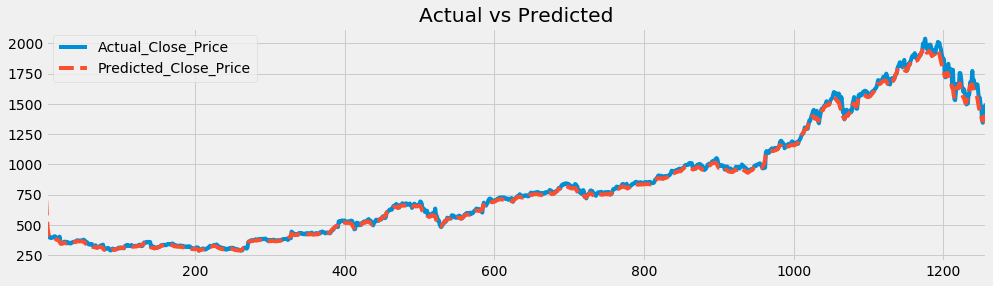

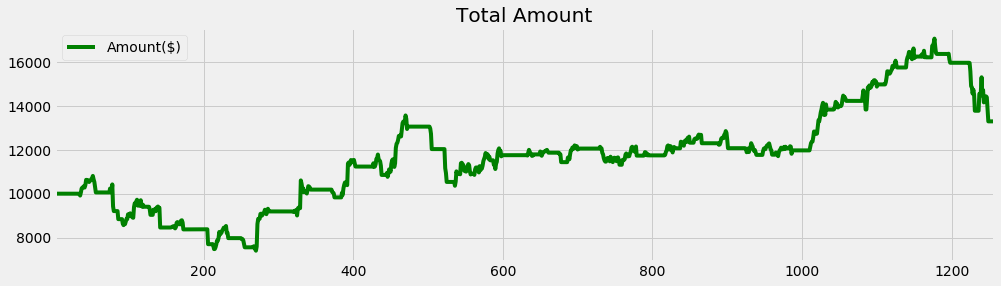

In [52]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [53]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 13300.0 $
Profit_Percent: 133.0 %


In [54]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [55]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0003075506419130009 0.012741104098963412


0.7148408629800209

# 4. Model evaluaion

* rmse

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [58]:
sqrt(rms)

5.126630824290353

* r-square

In [59]:
from sklearn.metrics import r2_score

r2_score(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']) 

0.9969615467137605

# Use Package and smaCross strategy to backTesting

In [60]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [63]:
!pip install Backtesting

  Using cached https://files.pythonhosted.org/packages/60/7a/e881b5abb54db0e6e671ab088d079c57ce54e8a01a3ca443f561ccadb37e/typing_extensions-3.7.4.3-py3-none-any.whl
  Found existing installation: bokeh 1.3.4
    Uninstalling bokeh-1.3.4:
      Successfully uninstalled bokeh-1.3.4


In [64]:
from backtesting.test import SMA


C:\Users\Siddhi\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [66]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [67]:
from backtesting import Backtest

bt = Backtest(df_amzn, SmaCross, cash=10000, commission=.002)
bt.run()

Start                     2014-01-02 00:00:00
End                       2018-12-31 00:00:00
Duration                   1824 days 00:00:00
Exposure Time [%]                     96.8203
Equity Final [$]                      41086.2
Equity Peak [$]                       55361.4
Return [%]                            310.862
Buy & Hold Return [%]                 277.408
Return (Ann.) [%]                     32.7194
Volatility (Ann.) [%]                 40.2231
Sharpe Ratio                         0.813447
Sortino Ratio                         1.68659
Calmar Ratio                         0.964541
Max. Drawdown [%]                    -33.9223
Avg. Drawdown [%]                    -3.87916
Max. Drawdown Duration      332 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                    1
Win Rate [%]                              100
Best Trade [%]                          320.3
Worst Trade [%]                         320.3
Avg. Trade [%]                    

In [68]:
bt.plot()